# CNN AutoEncoder on the Mnist Dataset

In this project, I will implement a CNN autoencoder for the Fashion-MNIST dataset, and examine the learned encodings.

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
#load and normalise data

(x_train,y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train =x_train / 255.
x_test = x_test / 255

#store class names
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

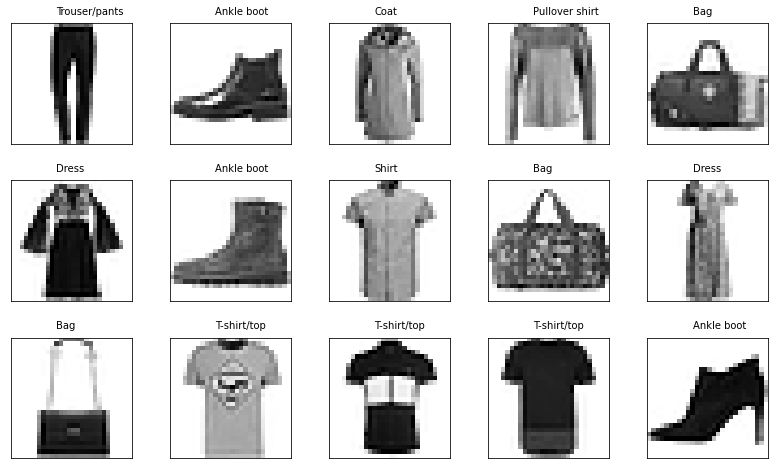

In [3]:
# Display a few examples

import matplotlib.pyplot as plt

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(x_train.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for n, (image, label) in enumerate(zip(x_train[inx], y_train[inx])):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='binary')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -2.5, f'{class_names[label]}')
plt.show()

# CNN AutoEncoder

## Encoder Network

the goal of the encoder network is to take our data examples and try to learn an encoding (decompression) to a lower dimensional latent space. For this project I will map the data to a two dimensional latent space such that it is easy to view the encoding visually.

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential

cnn_encoder = Sequential([
    Conv2D(16, (5,5), input_shape=(28,28,1), activation='relu'),
    MaxPool2D(2),
    Conv2D(8, (5,5), activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2) #keep logits
])

cnn_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 8)           3208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [5]:
# now we have our encoder network lets compute some encodings before training - so that we can compare!

#select 1000 random indexs from x_test (10000, 28, 28)
inx = np.random.choice(x_test.shape[0], 1000, replace=False)

random_sample_x = x_test[inx]
random_sample_y = y_test[inx]
#take those indexs and grab the associated samples --> feed into the encoder
untrained_encodings = cnn_encoder(random_sample_x).numpy()
untrained_encoding_labels = random_sample_y

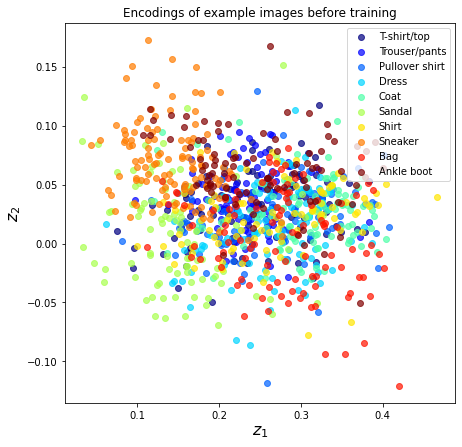

In [6]:
# Plot untrained encodings

from matplotlib import cm

plt.figure(figsize=(7, 7))
cmap = cm.get_cmap('jet', 10)
for i, class_label in enumerate(class_names):
    inx = np.where(untrained_encoding_labels == i)[0]
    plt.scatter(untrained_encodings[inx, 0], untrained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()
plt.show()

## which looks like a bit of a mess! there has been no training yet !

## Decoder

The goal of the decoder is to take a sample from the encoded latent space and decode. (i.e. work back upwards to reconstruct an image)

In [7]:
from tensorflow.keras.layers import Conv2DTranspose, Reshape, UpSampling2D

cnn_decoder = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(128, activation='relu'),
    #converse of flatten is to reshape to dims of input to flatten layer (in encoder)
    Reshape((4,4,8)),
    UpSampling2D((2,2)),
    #8 filters (stacked in channel dim) no padding and usual strides:
    Conv2DTranspose(8, (5,5), activation='relu'), 
    UpSampling2D((2,2)),
    Conv2DTranspose(1, (5,5), activation='sigmoid') #sigmoid -- because pixel values are in the range of (0,1).   
])

cnn_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 8)           0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 8)         1608      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)        

## Define AutoEncoder

In [8]:
from tensorflow.keras.models import Model

cnn_autoencoder = Model(inputs=cnn_encoder.inputs, outputs = cnn_decoder(cnn_encoder.outputs))

## Create Dataset Objects

In [9]:
#load into tfdataset onjects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))

#shuffle and batch datasets
train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
### Compile and Fit

# use BinaryCrossEntopy to compare the outputs of decoder with the original input -- makes sense 
# as the normalised pixel values fall between (0,1)

cnn_autoencoder.compile(loss='binary_crossentropy') 
cnn_autoencoder.fit(train_dataset, epochs=10)

Epoch 1/10
938/938 [==============================] - 18s 19ms/step - loss: 0.4051
Epoch 2/10
938/938 [==============================] - 18s 19ms/step - loss: 0.3542
Epoch 3/10
938/938 [==============================] - 18s 19ms/step - loss: 0.3445
Epoch 4/10
938/938 [==============================] - 18s 19ms/step - loss: 0.3394
Epoch 5/10
938/938 [==============================] - 18s 19ms/step - loss: 0.3364
Epoch 6/10
938/938 [==============================] - 19s 20ms/step - loss: 0.3345
Epoch 7/10
938/938 [==============================] - 19s 21ms/step - loss: 0.3332
Epoch 8/10
938/938 [==============================] - 19s 21ms/step - loss: 0.3323
Epoch 9/10
938/938 [==============================] - 19s 21ms/step - loss: 0.3315
Epoch 10/10
938/938 [==============================] - 19s 21ms/step - loss: 0.3308


## Results

I'll take the same examples from the test_set as before and and compute the encodings (using the trained encoder) and see how this changes compared to the untrained encodings shown above

In [11]:
# Compute encodings after training

trained_encodings = cnn_encoder(random_sample_x).numpy()
trained_encoding_labels = random_sample_y

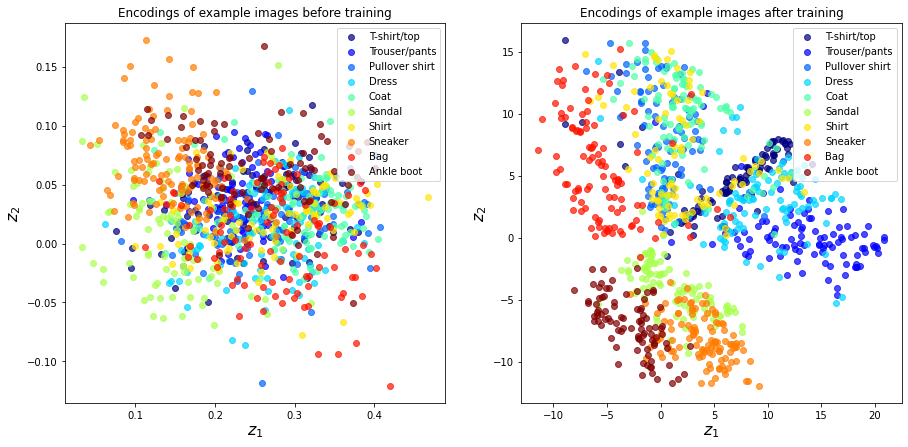

In [12]:
# Plot untrained and trained encodings

from matplotlib import cm

plt.figure(figsize=(15, 7))
cmap = cm.get_cmap('jet', 10)

plt.subplot(1, 2, 1)
for i, class_label in enumerate(class_names):
    inx = np.where(untrained_encoding_labels == i)[0]
    plt.scatter(untrained_encodings[inx, 0], untrained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images before training')
plt.legend()

plt.subplot(1, 2, 2)
for i, class_label in enumerate(class_names):
    inx = np.where(trained_encoding_labels == i)[0]
    plt.scatter(trained_encodings[inx, 0], trained_encodings[inx, 1],
                color=cmap(i), label=class_label, alpha=0.7)
plt.xlabel('$z_1$', fontsize=16) 
plt.ylabel('$z_2$', fontsize=16)
plt.title('Encodings of example images after training')
plt.legend()

plt.show()

## Conclusion

So we can see that the clusters are far more condensed after the trained encoding meaning that our encoder is in fact encoding. Intrestingly we see that clothing that are similar in shape and wear are more closely clustered - with overlaps. For example 'ankle boot' (brown), 'sneaker' (orange) and 'sandal' (light green) are seperate from the other clusters! This makes sense since footwear have features that are seperate and distingwishable from clothing and hence are represented seperately in the latent (encoding) space! We can also see that clothing that is similar and hence share similar features overlap in the latent space. Shirt (yellow), for example has a large spread and overlaps several classes, but doesnt overlap (as heavely) trousers (light purple). 

Given that we have taken a (28,28,1) image and compressed it down to a (2,) dimenional space, we see that relatively large amounts of infomation remain and that there is infact some interprebility from the clusterings! 